# Demo for Linear Hybrid Payoff Bandits

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from utils import create_reward_plot, plot_regret, create_result_dict, plot_action_freq
import matplotlib.pyplot as plt
from algorithms.linear import HyLinUCB, DisLinUCB, LinUCBLangford, LinUCB, SupLinUCB
from environment import HybridBandits

In [2]:
def probe_algo(env: HybridBandits, algo_arr, nrows, ncols):
    theta_dict = {}
    beta_dict = {}
    algo_dict = {}
    for algo in algo_arr:
        if algo.name.startswith('LinUCBLangford'):
            theta_dict['LinUCBLangford'] = algo.theta_hat
            beta_dict['LinUCBLangford'] = algo.beta_hat_arr
            algo_dict['LinUCBLangford'] = algo
        elif algo.name.startswith('DisLinUCB'):
            theta_dict['DisLinUCB'] = algo.theta_hat_arr
            algo_dict['DisLinUCB'] = algo
        elif algo.name.startswith('HyLinUCB'):
            theta_dict['HyLinUCB'] = algo.theta_hat
            beta_dict['HyLinUCB'] = algo.beta_hat_arr
            algo_dict['HyLinUCB'] = algo
        elif algo.name.startswith('LinUCB'):
            theta_dict['LinUCB'] = algo.theta_hat
            algo_dict['LinUCB'] = algo
    if ncols <= 1:
        fig, ax = plt.subplots(nrows, sharex=False, sharey=False, figsize=(30, 30))
        x = 0
        base = np.arange(1, env.L + 1)
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            reward_arr = np.zeros((env.L, 2*(len(algo_arr)+1)))
            reward_bonuses = np.zeros((env.L, len(algo_arr)+1))
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr[j, 0], reward_arr[j, 1] = np.dot(theta, a), np.dot(beta_arr[j], b)
                for k, keyname in enumerate(algo_dict.keys()):
                    if keyname == 'DisLinUCB':
                        reward_arr[j, 2*(k+1)] = np.dot(theta_dict['DisLinUCB'][j][:env.d], a)
                        reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict['DisLinUCB'][j][env.d:], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=np.concatenate((a,b))) - s
                    elif keyname == 'LinUCB':
                        reward_arr[j, 2*(k+1)] = np.dot(theta_dict['LinUCB'][:env.d], a)
                        reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict['LinUCB'][env.d + j*env.k: env.d + (j+1)*env.k], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        ar = np.zeros((env.d + env.k*env.L,))
                        ar[:env.d] = a
                        ar[env.d + j*env.k: env.d + (j+1)*env.k] = b
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=ar) - s
                    else:
                        reward_arr[j, 2*(k+1)], reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict[keyname], a), np.dot(beta_dict[keyname][j], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=(a,b)) - s
            columns = ['True_theta', 'True_beta']
            col_theta, col_beta = ['True_theta'], ['True_beta']
            for k in algo_dict.keys():
                columns += [k + '_theta']
                col_theta += [k + '_theta']
                columns += [k + '_beta']
                col_beta += [k + '_beta']
            df = pd.DataFrame(reward_arr, columns=columns, index=base)
            width = 0.2
            l = 0
            for col in col_theta:
                offset = width * l
                ax[x].bar(x=base + offset, height=df[col], width=width, label=col)
                l += 1
            l = 0
            for c1, c2 in zip(col_beta, col_theta):
                offset = width * l
                ax[x].bar(x=base + offset, height=df[c1], bottom=df[c2], width=width, yerr=reward_bonuses[:, l], label=c1)
                l += 1
            ax[x].legend().set_visible(False)
            ax[x].set_title(f'Context:{i}')
            ax[x].grid()
            x += 1
        handles, labels = ax[-1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
        plt.show()
    else:
        fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(30, 30))
        x, y = 0, 0
        base = np.arange(1, env.L + 1)
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            if x == nrows:
                x = 0
                y += 1
            reward_arr = np.zeros((env.L, 2*(len(algo_arr)+1)))
            reward_bonuses = np.zeros((env.L, len(algo_arr)+1))
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr[j, 0], reward_arr[j, 1] = np.dot(theta, a), np.dot(beta_arr[j], b)
                for k, keyname in enumerate(algo_dict.keys()):
                    if keyname == 'DisLinUCB':
                        reward_arr[j, 2*(k+1)] = np.dot(theta_dict['DisLinUCB'][j][:env.d], a)
                        reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict['DisLinUCB'][j][env.d:], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=np.concatenate((a,b))) - s
                    elif keyname == 'LinUCB':
                        reward_arr[j, 2*(k+1)] = np.dot(theta_dict['LinUCB'][:env.d], a)
                        reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict['LinUCB'][env.d + j*env.k: env.d + (j+1)*env.k], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        ar = np.zeros((env.d + env.k*env.L,))
                        ar[:env.d] = a
                        ar[env.d + j*env.k: env.d + (j+1)*env.k] = b
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=ar) - s
                    else:
                        reward_arr[j, 2*(k+1)], reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict[keyname], a), np.dot(beta_dict[keyname][j], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=(a,b)) - s
            columns = ['True_theta', 'True_beta']
            col_theta, col_beta = ['True_theta'], ['True_beta']
            for k in algo_dict.keys():
                columns += [k + '_theta']
                col_theta += [k + '_theta']
                columns += [k + '_beta']
                col_beta += [k + '_beta']
            df = pd.DataFrame(reward_arr, columns=columns, index=base)
            width = 0.2
            l = 0
            for col in col_theta:
                offset = width * l
                ax[x][y].bar(x=base + offset, height=df[col], width=width, label=col)
                l += 1
            l = 0
            for c1, c2 in zip(col_beta, col_theta):
                offset = width * l
                ax[x][y].bar(x=base + offset, height=df[c1], bottom=df[c2], width=width, yerr=reward_bonuses[:, l], label=c1)
                l += 1
            ax[x][y].legend().set_visible(False)
            ax[x][y].set_title(f'Context:{i}')
            ax[x][y].grid()
            x += 1
        handles, labels = ax[-1][-1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
        plt.show()

In [4]:
def plot_norm_ratios(algo:LinUCB, nc):
    T = len(algo.V_inv_norm[0])
    nr = algo.L // nc
    fig, ax = plt.subplots(nr, nc, figsize=(20, 20))
    x, y = 0, 0
    for i in range(algo.L):
        ax[x][y].plot(np.arange(1, T+1), np.array(algo.V_inv_norm[i])/np.array(algo.I_minus_A_by_2[i]), label='M^(-1)//(I-A/2)^(-1)')
        #ax[x][y].plot(np.arange(1, T+1), np.array(algo.V_inv_norm[i])/np.array(algo.block_matrix_norm[i]), label='U^(-1/2)(I-A/2)^(-1)U^(-1/2)')
        ax[x][y].legend()
        ax[x][y].set_title(f'Arm {i+1}')
        ax[x][y].grid()
        y += 1
        if y == nc:
            y = 0
            x += 1
    plt.show()

In [49]:
def plot_eig_val(algo:LinUCB):
    fig, ax = plt.subplots()
    T = len(algo.min_eig_val_A)
    ax.plot(np.arange(1, T+1), algo.min_eig_val_A, label='Min Eigval')
    #ax.plot(np.arange(1, T+1), algo.max_eig_val_A, label='Max Eigval')
    ax.grid()
    ax.legend()
    ax.set_title('Eigenvalues of A')
    plt.show()

In [6]:
# Function to run 1 trial
def simulate(env, algo_arr, T, display=None):
    d = {}
    nr = 5
    for algo in algo_arr:
        if algo.name.startswith('LinUCBLangford'):
            d['LinUCBLangford'] = []
        elif algo.name.startswith('DisLinUCB'):
            d['DisLinUCB'] = []
        elif algo.name.startswith('LinUCB'):
            d['LinUCB'] = []
        elif algo.name.startswith('SupLinUCB'):
            d['SupLinUCB'] = []
    con_act_ls = [deepcopy(d) for _ in range(env.num_context)]
    for t in tqdm(range(T)):
        t = t % T
        a_t = []
        context_id = env.context_seq[env.t]
        for algo in algo_arr:
            a = algo.next_action()
            if algo.name.startswith('LinUCBLangford'):
                con_act_ls[context_id]['LinUCBLangford'].append(a)
            elif algo.name.startswith('DisLinUCB'):
                con_act_ls[context_id]['DisLinUCB'].append(a)
            elif algo.name.startswith('LinUCB'):
                con_act_ls[context_id]['LinUCB'].append(a)
            elif algo.name.startswith('SupLinUCB'):
                con_act_ls[context_id]['SupLinUCB'].append(a)
            a_t.append(a)
        rewards_t, regrets_t, action_set_t = env.step(a_t)
        for i, algo in enumerate(algo_arr):
            algo.update(rewards_t[i], regrets_t[i], action_set_t)
        if display is not None:
            if ((t+1) % display) == 0:
                print('Timestep:', (t+1))
                probe_algo(env, algo_arr, nrows=nr, ncols=env.num_context // nr)
    #plot_action_freq(con_act_ls, env, nrows=nr, ncols=env.num_context // nr)
    #plot_norm_ratios(algo_arr[0], 2)
    plot_eig_val(algo_arr[0])
    return con_act_ls

In [9]:
def multi_simulation(num_trials, algo_dict, env:HybridBandits, delta:float, T:int, display:int):
    all_rewards = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]
    all_regrets = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]
    for i in range(num_trials):
        algo_arr = []
        for k in algo_dict.keys():
            if k == 'DisLinUCB':
                lmbda = algo_dict[k]['lambda']
                algo_arr.append(DisLinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, env.sigma, lmbda))
            elif k == 'LinUCBLangford':
                alpha = algo_dict[k]['alpha']
                algo_arr.append(LinUCBLangford(env.get_first_action_set(), env.M, env.N, env.S1, env.S2, alpha))
            elif k == 'LinUCB':
                lmbda = algo_dict[k]['lambda']
                algo_arr.append(LinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, env.sigma, lmbda))
            elif k == 'SupLinUCB':
                lmbda = algo_dict[k]['lambda']
                algo_arr.append(SupLinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, env.sigma, lmbda, T))
        print('Simulating Trial', i+1)
        ls = simulate(env, algo_arr, T, display=display)
        env.reset()
        for j in range(len(algo_arr)):
            all_rewards[j][i] += np.array(algo_arr[j].rewards)
            all_regrets[j][i] += np.array(algo_arr[j].regrets)
    return all_rewards, all_regrets, ls

In [68]:
# Define Environment Configuration

config = {}
config['seed'] = 984397                 #np.random.randint(1098321) # Uncomment the random seed generator for random instances
print('Seed:', config['seed'])
config['model_type'] = 'Linear'
config['horizon_length'] = 3000       # Number of time steps T
config['num_labels'] = 10               # Number of actions L
config['num_context'] = 10              # Context set size
config['theta_dim'] = 1                 # Dimension of theta d
config['beta_dim'] = 3                  # Dimension of beta k
config['theta_norm'] = 0.8              # Max norm of theta M
config['beta_norm'] = 0.2               # Max norm of beta_i's N
config['x_norm'] = 1.0                  # Max norm of x
config['z_norm'] = 1.0                  # Max norm of z
config['subgaussian'] = 0.01             # Subgaussianity of noise
config['arm_desc'] = None                # Description for the set of arms that environment generates -- 'easy': large suboptimality gap, 'proportional': z_i = 0.3 * x_i
env_name = 'Testbench'                  # Name of the simulation

Seed: 984397


In [69]:
env = HybridBandits(name=env_name, config=config)

In [70]:
nrows = env.num_context // 10
#create_reward_plot(env, nrows, 10)

In [71]:
# Add the algorithms to test and their hyperparameters
algo_dict = {'LinUCB': {'lambda': 0.1},
             'LinUCBLangford': {'alpha': 0.1},
             'DisLinUCB': {'lambda': 0.1}}
             #'MixedLinUCB': {'lambda': 0.1}}
delta = 0.001 # High probability guarantee

In [72]:
# Code to run multiple trials

num_trials = 1  # Number of trials
T = env.T
display = T // 5

In [73]:
env.reset()

Simulating Trial 1


100%|██████████| 3000/3000 [00:11<00:00, 259.92it/s]


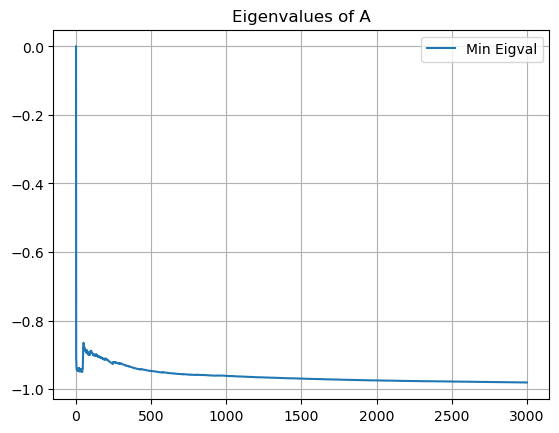

In [74]:
rewards, regrets, ls = multi_simulation(num_trials, algo_dict, env, delta, T, display=None)
result_dict = create_result_dict(rewards, regrets, algo_dict)

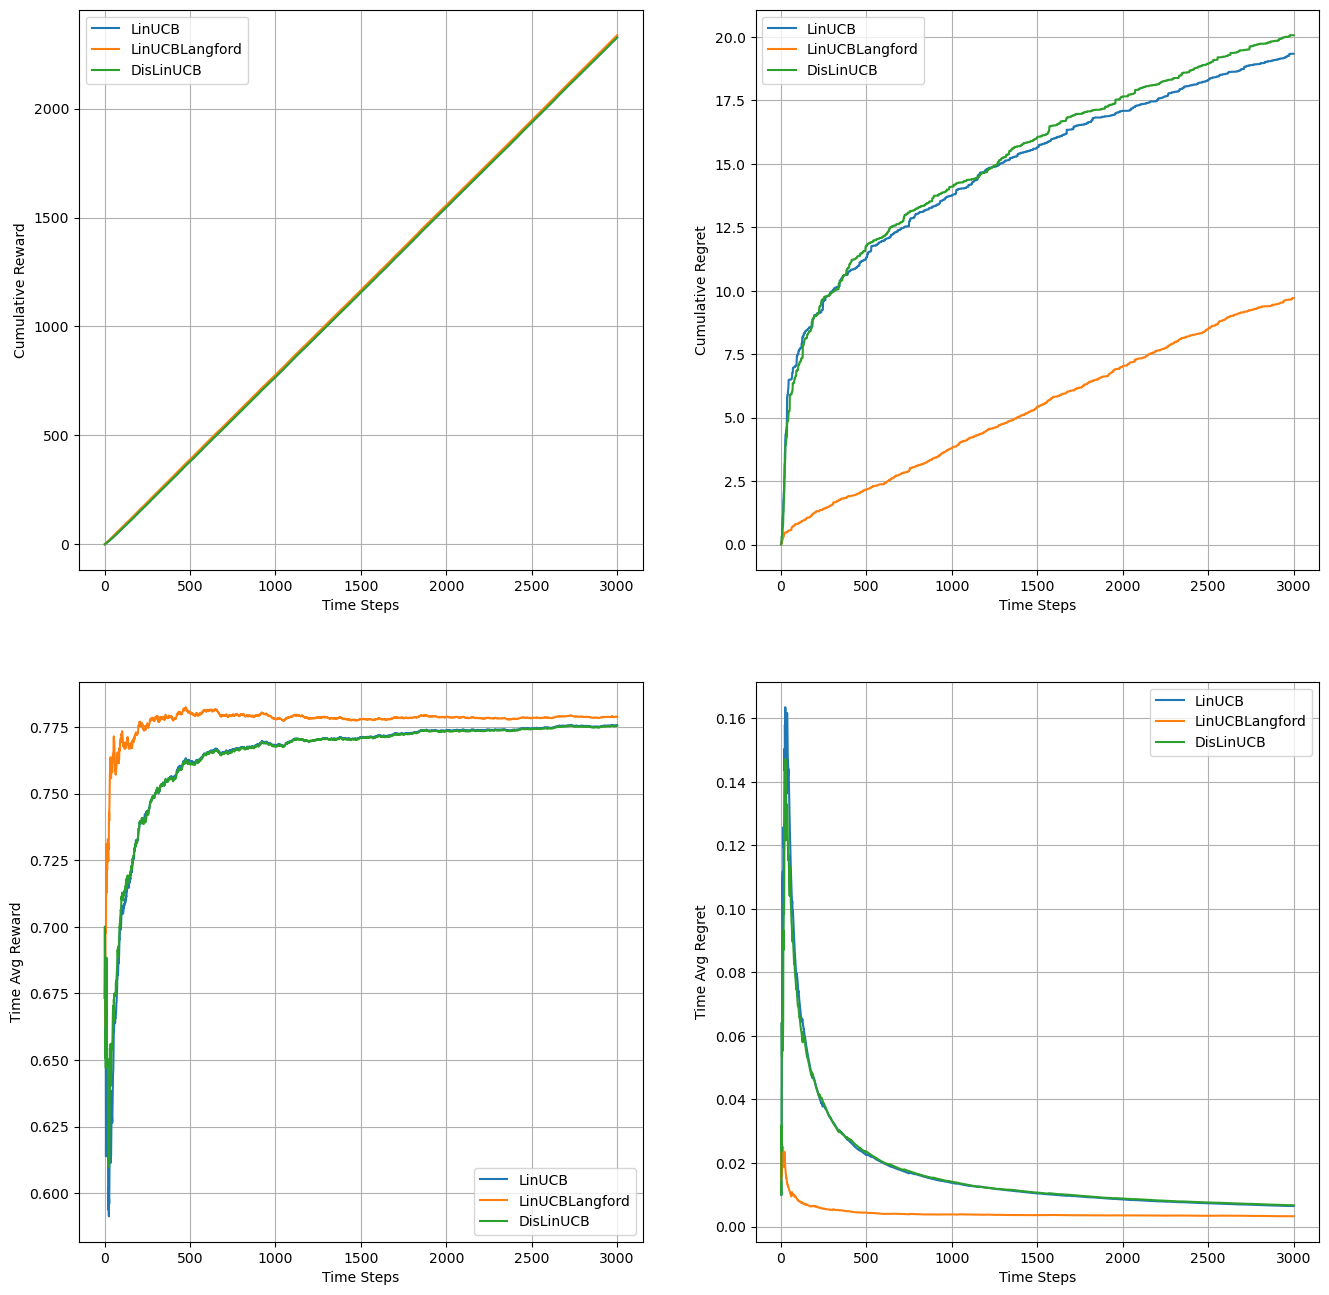

In [75]:
plot_regret(result_dict, env.T)

#### Variation of Regret with Number of Arms

In [48]:
# Define Environment Configuration

config = {}
config['seed'] = 984397                 #np.random.randint(1098321) # Uncomment the random seed generator for random instances
print('Seed:', config['seed'])
config['model_type'] = 'Linear'
config['horizon_length'] = 3000       # Number of time steps T
config['num_context'] = 10000              # Context set size
config['theta_dim'] = 5                 # Dimension of theta d
config['beta_dim'] = 5                  # Dimension of beta k
config['theta_norm'] = 0.0              # Max norm of theta M
config['beta_norm'] = 1.0               # Max norm of beta_i's N
config['x_norm'] = 1.0                  # Max norm of x
config['z_norm'] = 1.0                  # Max norm of z
config['subgaussian'] = 0.01             # Subgaussianity of noise
config['arm_desc'] = 'proportional'     # Description for the set of arms that environment generates -- 'easy': large suboptimality gap, 'proportional': z_i = 0.3 * x_i
env_name = 'Testbench'                  # Name of the simulation

Seed: 984397


In [ ]:
L_arr = [9, 16, 25, 36, 49, 64, 81, 100, 121, 144]
#L_arr = [9, 16]
num_trials = 1
T = 3000
reg_arr = {'LinUCB': [], 'LinUCBLangford': [], 'DisLinUCB': []}
reg_std_arr = {'LinUCB': [], 'LinUCBLangford': [], 'DisLinUCB': []}

for L in L_arr:
    config['num_labels'] = L
    env = HybridBandits(env_name, config)
    print('Running L=', L)
    rewards, regrets, ls = multi_simulation(num_trials, algo_dict, env, T, display)
    result_dict = create_result_dict(rewards, regrets)
    for k in result_dict.keys():
        reg_arr[k].append(result_dict[k]['mean_regret'][-1])
        reg_std_arr[k].append(result_dict[k]['std_regret'][-1])

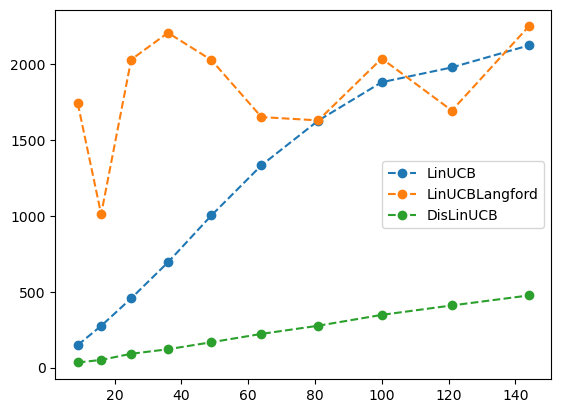

In [ ]:
for k in result_dict.keys():
    plt.plot(L_arr, reg_arr[k], '--o', label=k)

plt.legend()
plt.show()

In [ ]:
x = np.ones(shape=1)
np.dot(2*x[:-1]/np.linalg.norm(x[:-1]), np.array([])) + 1

1.0

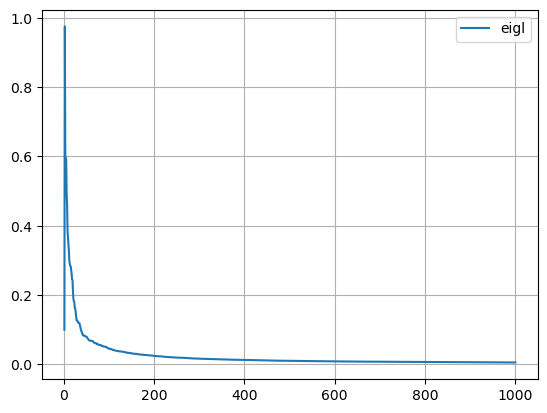

In [ ]:
eig_valh = [0.1]
eig_vall = [0.1]
norm_val = []
A = 0.1*np.eye(5)
T = 1000

for i in range(1, T):
    # x = np.random.uniform(-1, 1, (5,))
    # x = np.random.uniform(0,1)*(x / np.linalg.norm(x))
    x = np.random.standard_normal((6,))
    x = x[:-1] / np.linalg.norm(x)
    A = A + np.outer(x, x)
    w = np.linalg.eigvalsh(np.linalg.inv(A))
    eig_valh.append(w[-1])
    eig_vall.append(w[0])
    norm_val.append(np.linalg.norm(x))

#plt.plot(np.arange(1, T+1), eig_valh, label='eigh')
plt.plot(np.arange(1, T+1), eig_vall, label='eigl')
#plt.plot(np.arange(1, T), norm_val, label='norm')
plt.grid()
plt.legend()
plt.show()

In [35]:
stats = {'a': (1,2000), 'b': (3000,2), 'c': (0,1)}
max(stats, key=lambda x: stats.get(x)[1])

'a'